In [1]:
import sys ; sys.path.insert(0, "..")

from collections import defaultdict
from src.graphs import DeBruijnGraph

def count_kmers(seq, k):

    kmer_count = defaultdict(int)
    for pos in range(len(seq)-k+1):
        kmer = seq[pos:pos+k]
        kmer_count[kmer] += 1

    return kmer_count    

In [5]:
k   =  2
seq = "AATGCCATGGG"

In [6]:
dbg = DeBruijnGraph(sequence=seq, k=k)

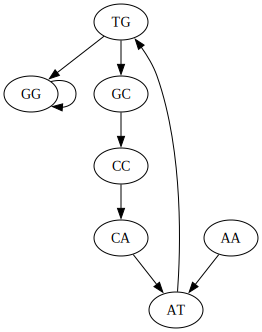

In [7]:
dbg.show()

In [5]:
edges = dbg.edges

In [6]:
nodes = dbg.nodes

___
### torch dBG loader


In [7]:
import torch
from torch_geometric.data import Data

In [8]:
def create_torch_graph(nodes: set, edges: list, kmer_count: dict):

    idx_nodes = {kmer: idx  for idx, kmer in  enumerate(nodes)}
    
    # nodes
    feat_nodes = [ [kmer_count[kmer]] for kmer in dbg.nodes]
    x = torch.tensor(feat_nodes, dtype=torch.float)

    # edges    
    edges =  list(map( lambda x: (idx_nodes[x[0]],idx_nodes[x[1]]) , dbg.edges))
    edge_index = torch.tensor(edges, dtype=torch.long)    

    return Data(x=x, edge_index=edge_index.t().contiguous())

In [9]:
kmer_count = count_kmers(seq, k)
create_torch_graph(nodes, edges, kmer_count)

Data(x=[11, 1], edge_index=[2, 13])

In [10]:
idx_nodes = {kmer: idx  for idx, kmer in  enumerate(dbg.nodes)}
idx_nodes

{'AA': 0,
 'TA': 1,
 'GT': 2,
 'CC': 3,
 'CA': 4,
 'TT': 5,
 'AT': 6,
 'GG': 7,
 'GA': 8,
 'TG': 9,
 'GC': 10}

In [11]:
edges =  list(map( lambda x: (idx_nodes[x[0]],idx_nodes[x[1]]) , dbg.edges))
edges

[(7, 8),
 (6, 9),
 (9, 10),
 (9, 2),
 (2, 5),
 (10, 3),
 (0, 6),
 (7, 7),
 (8, 6),
 (1, 0),
 (9, 7),
 (4, 6),
 (3, 4)]

In [12]:
# edges as torch tensors
edge_index = torch.tensor(edges, dtype=torch.long)

In [13]:
# node features (kmer frequencies)
feat_nodes = [ [kmer_count[kmer]] for kmer in dbg.nodes]
x = torch.tensor(feat_nodes, dtype=torch.float)
x

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.]])

In [14]:
data = Data(x=x, edge_index=edge_index.t().contiguous())

In [15]:
data

Data(x=[11, 1], edge_index=[2, 13])

In [16]:
data.validate(raise_on_error=True)

True

In [17]:
data.keys()

['edge_index', 'x']

In [18]:
data["x"]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.]])

In [19]:
data["edge_index"]

tensor([[ 7,  6,  9,  9,  2, 10,  0,  7,  8,  1,  9,  4,  3],
        [ 8,  9, 10,  2,  5,  3,  6,  7,  6,  0,  7,  6,  4]])

In [20]:
data.has_self_loops()

True

In [21]:
data.is_directed()

True

___
### DataLoader

In [22]:
from torch_geometric.loader import DataLoader

In [23]:
data_list = [data, data, data, data, data]
loader = DataLoader(data_list, batch_size=2)

In [24]:
for batch in loader:
    print(batch)

DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[11, 1], edge_index=[2, 15], batch=[11], ptr=[2])


In [25]:
from Bio import SeqIO

In [26]:
path_data = "../data/ecolik12_ont_0001.fastq"
with open(path_data) as fp:
    count = 0
    for fastq in SeqIO.parse(fp, format="fastq"):
        count +=1
    # read = next(fastq)

In [27]:
record_dict = SeqIO.index(path_data, format="fastq")

In [28]:
seq_ids = list(record_dict.keys())

In [29]:
record_dict[seq_ids[3]]

SeqRecord(seq=Seq('CGTAACGGTGGAGCTTGAGTAGAAAAACGCGACTTGGTTTTGTCTTTATTCACC...CAG'), id='ecoli1_4', name='ecoli1_4', description='ecoli1_4', dbxrefs=[])

In [30]:
len(seq_ids)

10254

In [42]:
import os.path as osp

from pathlib import Path
from torch_geometric.data import Dataset

class dBGDataset(Dataset):

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        self.path_fastq = "../data/ecolik12_ont_0001.fastq"
        self.list_files = "data/ecolik12_ont_0001.fastq"
        self.k = 6
        super().__init__(root, transform, pre_transform, pre_filter)
        

    @property
    def raw_file_names(self,):
        return self.list_files

    @property
    def processed_file_names(self,):
        processed_filename = [f"data_{x}" for x in range(10)]
        return processed_filename

    def _process(self):
        idx = 0
        self.path_fastq
        record_dict = SeqIO.index(self.path_fastq, format="fastq")
        seq_ids = list(record_dict.keys())

        for seq_id in seq_ids[:10]:
            print(f"Building {seq_id}")
            # Read data from `raw_path`.
            record = record_dict[seq_id]
            seq = record.seq
            dbg = DeBruijnGraph(sequence=seq, k=k)
            kmer_count = count_kmers(seq, k)
            data = create_torch_graph(dbg.nodes, dbg.edges, kmer_count)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            Path(self.processed_dir).mkdir(exist_ok=True, parents=True)
            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [43]:
dbg_dataset = dBGDataset(root="../output-pyg")

In [44]:
dbg_dataset._process()

Building ecoli1_1
Building ecoli1_2
Building ecoli1_3
Building ecoli1_4
Building ecoli1_5
Building ecoli1_6
Building ecoli1_7
Building ecoli1_8
Building ecoli1_9
Building ecoli1_10


In [45]:
g = dbg_dataset.get(1)
g

Data(x=[11, 1], edge_index=[2, 15])

In [46]:
g["edge_index"]

tensor([[ 1,  2,  4,  7,  8,  3,  9,  4,  7,  5,  5,  0,  4,  7,  6],
        [ 2,  4,  7,  8,  3,  9,  4,  7,  5,  5,  0,  4,  7,  6, 10]])

In [47]:
from torch_geometric.loader import DataLoader

In [48]:
loader = DataLoader(dbg_dataset, batch_size=2, )
loader

In [49]:
dp = dbg_dataset.to_datapipe()

In [50]:
for batch in loader:
    print(batch)

DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
